In [2]:
import scipy.optimize as spo
import scipy.integrate as si
import numpy as np
from numpy import exp, log, sqrt, sign
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['text.usetex'] = True

# Implementation of Section III

In [84]:
# inverse temperature
β = 1.0

#### defining functions from the paper ####

#### NOTATION ####
# τ is the total protocol time
# K is the integration constant
# p0 is the initial value of p
# pτ is the value of p at time the final time τ
# E0 is the initial energy (before quench)
# Eτ is the final energy (after quench)
# p is the value of p at time t
# r is the degeneracy ratio r = m/n

# time is in units of nγ


# equibrium functions:
def p_eq(E,r):
    """
    Eq. 6: the equilibrium value of p at energy E for degeneracy ratio r.
    """
    return  1/(1 + r*exp(β*E))
def E_eq(p,r):
    """
    The energy such that energy at p is at equilibrium, for degeneracy ratio r.
    (inverting Eq. 6)
    """
    return log((1-p)/(r*p))/β

# Eq 13
def F(K,p,p0,r):
    """
    Eq. 13: the amount of time it takes to reach p from p0 (with the optimal protocol), with a given integration constant K.
    """
    # computing the sign of p_dot
    p_dot_sign = sign(p-p0)
    if p_dot_sign == 0:
        return 0.0

    # helper function to define the integrand
    def integrand(p):
        return 2*(1-(1-r)*p + K)/(K*(1-(1+r)*p) + p_dot_sign*sqrt(K**2*(1-(1-r)*p)**2 + 4*r*K*p*(1-p)*(1-(1-r)*p)))

    return si.quad(integrand,p0,p)[0]

# inverse of F
def F_inv(K,t,p0,r,p_dot_sign):
    """
    Eq. 13: optimal p(t) for a given integration constant K.
    p_dot_sign is the sign of p_dot, which is -1 for decreasing p and +1 for increasing p.
    """
    if t == 0:
        return p0

    # making sure p_dot_sign is either -1 or +1
    if p_dot_sign > 0:
        p_dot_sign = 1
    elif p_dot_sign < 0:
        p_dot_sign = -1
    else:
        p_dot_sign = -1

    if p_dot_sign < 0:
        pmin = 1e-10
        while F(K,pmin,p0,r) - t < 0:
            pmin /= 10
        return spo.brentq(lambda p: F(K,p,p0,r) - t, pmin, p0)
    else:
        return spo.brentq(lambda p: F(K,p0,p,r) - t, p0, 1)

# Eq 15
def E(K,p,r,p_dot_sign):
    """
    Eq. 15: the optimal energy of the system at time t, given the integration constant K and the degeneracy ratio r.
    p_dot_sign is the sign of p_dot, which is -1 for decreasing p and +1 for increasing p.
    """
    # making sure p_dot_sign is either -1 or +1
    if p_dot_sign > 0:
        p_dot_sign = 1
    elif p_dot_sign < 0:
        p_dot_sign = -1
    else:
        p_dot_sign = -1

    sqrtΔ = sqrt(K**2*(1-(1-r)*p)**2 + 4*r*K*p*(1-p)*(1-(1-r)*p))
    num = (1-(1-r)*p)*(K+2*(1-p)) - p_dot_sign*sqrtΔ
    den = (1-(1-r)*p)*(K+2*r*p) + p_dot_sign*sqrtΔ
    return log(num/den)/β


# Eq 16
def W(K,pτ,p0,Eτ,E0,r):
    """
    Eq. 16: the work done in the protocol, given the integration constant K,
    the initial and final values of p, the initial and final energies.
    """
    # computing the sign of p_dot
    p_dot_sign = sign(pτ-p0)
    
    # ΔΕ
    ΔE = Eτ*pτ - E0*p0
    if p_dot_sign == 0:
        return ΔE

    # Q
    def Q_int(p):
        return E(K,p,r,p_dot_sign)
    
    Q = si.quad(Q_int,p0,pτ)[0]
    return ΔE - Q


# Minimizing work

In [ ]:
# speed limit (integral of eq. 20)
def speed_limit(pτ,p0,r):
    """
    Eq. 20: the speed limit for the protocol, given the initial and final values of p and the degeneracy ratio r.
    """
    # computing the sign of p_dot
    p_dot_sign = sign(pτ-p0)
    if p_dot_sign == 0:
        return 0.0
    
    if p_dot_sign < 0:
        return log(p0/pτ)/r
    else:
        return log((1-p0)/(1-pτ))

# for fixed p(τ)
# solving eq. 14
def K_opt_fixed_pτ(pτ,p0,τ,r):
    """
    solving Eq. 14 to find the optimal integration constant K for a fixed p(τ).
    τ: total protocol time
    """
    τmin =  speed_limit(pτ,p0,r)
    if τ < τmin*(1+1e-8):
        # print('Warning: requested time too small, increasing it to the minimum')
        τ = τmin*(1+1e-8)

    # the optimization work better when the variation is done over log(K) instead of K
    xmin = -10
    xmax = 1
    while F(exp(xmax),pτ,p0,r) - τ > 0:
        xmax += 10
    while F(exp(xmin),pτ,p0,r) - τ < 0:
        xmin -= 2
        
    X = spo.brentq(lambda x: F(exp(x),pτ,p0,r) - τ, xmin, xmax)
        
    return exp(X)

# for non fixed p(τ), but fixed E(τ)
# minimizing the eq. 18
def K_opt_moving_pτ(Eτ,p0,τ,r):
    """
    minimizing Eq. 18 to find the optimal integration constant K for a moving p(τ) and fixed E(τ).
    τ: total protocol time
    """
    if p_eq(Eτ,r) > p0:
        p_dot_sign = 1
    else:
        p_dot_sign = -1
    
    # the optimization work better when the variation is done over log(K) instead of K
    eq18 = lambda x: W(exp(x),F_inv(exp(x),τ,p0,r,p_dot_sign),p0,Eτ,0,r)
    opt = spo.minimize(eq18,x0=-1)
    return exp(opt.x[0])

# returning the optimal energy using the previously defined functions
def EandP_opt_fixed_pτ(pτ,p0,τ,r):
    """
    This functions solves the minimization problem for fixed p(τ) and returns the energy function E(t) and p(t).

    returns: FUNCTIONS E and p, each takes as input time t and returns E(t) and p(t).
    """
    K = K_opt_fixed_pτ(pτ,p0,τ,r)

    p_fun = lambda t: F_inv(K,t,p0,r,sign(pτ-p0))
    E_fun = lambda t: E(K,p_fun(t),r,sign(pτ-p0))
    return E_fun, p_fun

def EandP_opt_moving_pτ(Eτ,p0,τ,r):
    """
    This functions solves the minimization problem for fixed E(τ) and returns the energy function E(t) and p(t).

    returns: FUNCTIONS E and p, each takes as input time t and returns E(t) and p(t).
    """
    K = K_opt_moving_pτ(Eτ,p0,τ,r)
    pτ = p_eq(Eτ,r)
    
    p_fun = lambda t: F_inv(K,t,p0,r,sign(pτ-p0))
    E_fun = lambda t: E(K,p_fun(t),r,sign(pτ-p0))
    return E_fun, p_fun

# Section VI: Bit Erasure

In [112]:
# list of values of r
r_list = [0.1,0.25,0.5,1,2,4,10]
# protocol time
τ = 3
print(f'computing the optimal erasure curves (total time: {τ}) for the following values of r {r_list}')

# initial energies such that p(0) = 1/2
E0_list = [-log(r)/β for r in r_list]

# choosing a fixed ΔE (large enough)
# this guarantees that the systems relax to the same final probability after the protocol
ΔE = 10/β
Eτ_list = [E0 + ΔE for E0 in E0_list]

# computing the optimal integration constant for each r
K_list = [K_opt_moving_pτ(Eτ_list[i],0.5,τ,r_list[i]) for i in range(len(r_list))]
print(f'optimal integration constants {K_list}')

# computing the optimal probability curve for each r
t_list = np.linspace(0,τ,100)
p_list = np.array([[F_inv(K_list[i],t,0.5,r_list[i],-1) for t in t_list] for i in range(len(r_list))])
print(f'computed the optimal probability curves')

# computing the optimal energy control corresponding to the probability curve
E_list = np.array([[E(K_list[i],p,r_list[i],-1) for p in p_list[i]] for i in range(len(r_list))])
print(f'computed the optimal energy control')

W_list = np.array([W(K_list[i],p_list[i,-1],0.5,Eτ_list[i],E0_list[i],r_list[i]) for i in range(len(r_list))])
print(f'computed the corresponding work costs: {W_list}')

computing the optimal erasure curves (total time: 3) for the following values of r [0.1, 0.25, 0.5, 1, 2, 4, 10]


/var/folders/cz/6ls2l9051bq0_wpn8p4ymfs00000gn/T/ipykernel_36566/618444729.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return si.quad(integrand,p0,p)[0]
/var/folders/cz/6ls2l9051bq0_wpn8p4ymfs00000gn/T/ipykernel_36566/618444729.py:111: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  Q = si.quad(Q_int,p0,pτ)[0]


optimal integration constants [0.2497176707872816, 0.39977024318992177, 0.41867061928613386, 0.3089284975159348, 0.18031735109953695, 0.1044835861952875, 0.06066176806772846]
computed the optimal probability curves
computed the optimal energy control
computed the corresponding work costs: [4.11977385 3.23100542 2.38391308 1.66039288 1.22377146 1.00796018
 0.88424806]


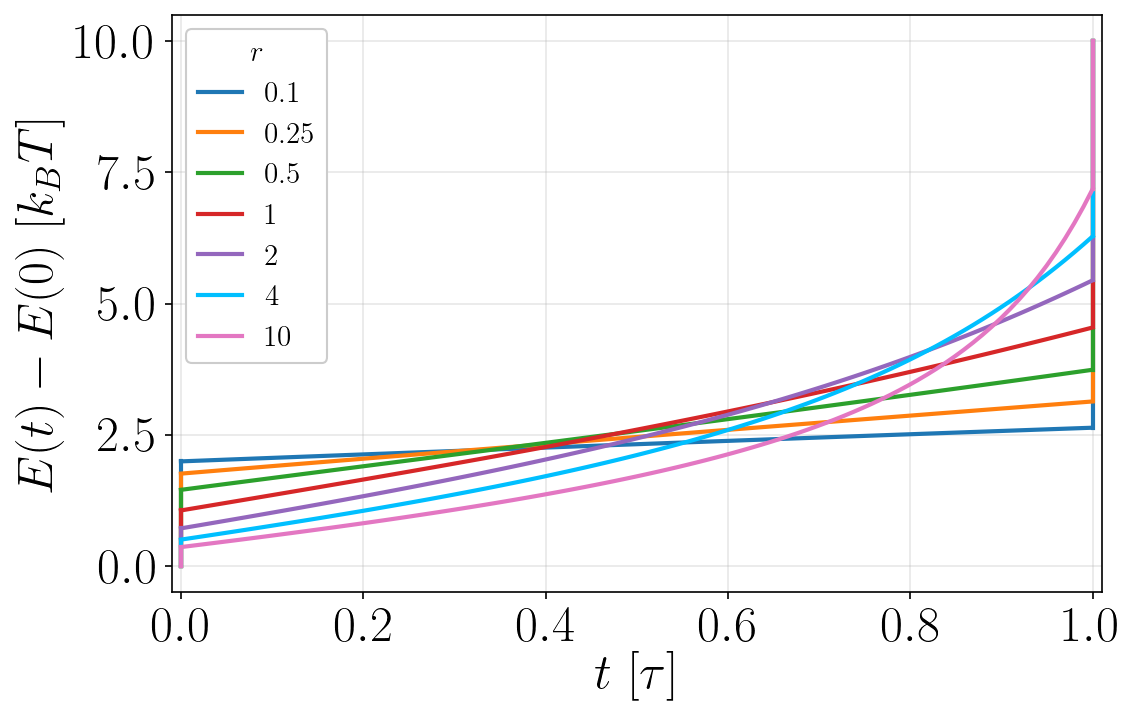

In [109]:
# plot

cols = ['C0','C1','C2','C3','C4','deepskyblue','C6']

plt_w = 8
plt.rcParams.update({'font.size': 24, 'font.family': 'Times New Roman'})
font = fm.FontProperties(family='Times New Roman', style='normal', weight='normal', size=14)
fig, (ax1) = plt.subplots(1, 1, dpi=150,figsize=(plt_w,plt_w/1.6))

lines = [] 
for i in range(len(r_list)):
    ax1.plot([0,0],[0,β*(E_list[i,0]-E0_list[i])], linewidth=2, color=cols[i])
    l, = ax1.plot(t_list/τ,β*(E_list[i]-E0_list[i]), linewidth=2, color=cols[i])
    ax1.plot([1,1],[β*(E_list[i,-1]-E0_list[i]), β*ΔE], linewidth=2, color=cols[i])
    lines.append(l)

ax1.set_xlabel(r'$t~[\tau]$',labelpad=0)

ax1.set_ylabel(r'$E(t)-E(0)~[k_BT]$',labelpad=5)
ax1.set_xlim([-0.01,1.01])
# ax1.set_ylim([0.005, 15])
# ax1.set_yscale('log')
# ax1.set_xscale('log')
ax1.grid(alpha=0.3)


ax1.legend(lines, r_list, loc='upper left', prop=font, handlelength=1.5, title=r'$r$', title_fontsize=14, framealpha=1)




In [ ]:
# list of values of r
# r_list = [0.1,0.25,0.5,1,2,4,10]
r_list = [0.1,0.33,1,3,10]
# r_list = [0.01,0.1,1,10,100]
# target probability
pτ = 1e-5
print(f'computing the optimal erasure curves (target probability: {pτ}) for the following values of r {r_list}')

# computing the minimal time corresponding to each r
τmin_list = [speed_limit(pτ, 0.5, r) for r in r_list]

print(f'minimal times to realize the protocol: {τmin_list}')

# for a fair comparison we choose the total times as a multiple of the allowed final time
τmult = 5
τ_list = [τ*τmult for τ in τmin_list]

# initial energies such that p(0) = 1/2
E0_list = [-log(r)/β for r in r_list]

# computing the final energies such that the final state is at equilibrium
Eτ_list = [E_eq(pτ,r) for r in r_list]


# computing the optimal integration constant for each r
K_list = [K_opt_fixed_pτ(pτ,0.5,τ_list[i],r_list[i]) for i in range(len(r_list))]
print(f'optimal integration constants {K_list}')

# computing the optimal probability curve for each r
t_list = np.linspace(0,1,100)
p_list = np.array([[F_inv(K_list[i],t*τ_list[i],0.5,r_list[i],-1) for t in t_list] for i in range(len(r_list))])
print(f'computed the optimal probability curves')

# computing the optimal energy control corresponding to the probability curve
E_list = np.array([[E(K_list[i],p,r_list[i],-1) for p in p_list[i]] for i in range(len(r_list))])
print(f'computed the optimal energy control')

W_list = np.array([W(K_list[i],pτ,0.5,Eτ_list[i],E0_list[i],r_list[i]) for i in range(len(r_list))])
print(f'computed the corresponding work costs: {W_list}')

# list of values of r
r_list2 = np.logspace(-2,3,100)

# computing the minimal time corresponding to each r
τmin_list2 = np.array([speed_limit(pτ, 0.5, r) for r in r_list2])

# for a fair comparison we choose the total times as a multiple of the allowed final time
τmult_list = [1.1,1.5,2,5,10]

# initial energies such that p(0) = 1/2
E0_list2 = [-log(r)/β for r in r_list2]

# computing the final energies such that the final state is at equilibrium
Eτ_list2 = [E_eq(pτ,r) for r in r_list2]

# computing the optimal integration constant for each r
K_list2 = np.array([[K_opt_fixed_pτ(pτ,0.5,τmin_list2[i]*τmult,r_list2[i]) for i in range(len(r_list2))] for τmult in τmult_list])

W_list2 = np.array([[W(K_list2[j,i],pτ,0.5,Eτ_list2[i],E0_list2[i],r_list2[i]) for i in range(len(r_list2))] for j in range(len(τmult_list))])


computing the optimal erasure curves (target probability: 1e-05) for the following values of r [0.1, 0.33, 1, 3, 10]
minimal times to realize the protocol: [108.19778284410283, 32.787206922455404, 10.819778284410283, 3.6065927614700946, 1.0819778284410284]
optimal integration constants [9.08519755773599e-05, 0.0003152670583863827, 0.0010843490350446415, 0.004286041180852957, 0.02402970207278668]
computed the optimal probability curves
computed the optimal energy control
computed the corresponding work costs: [0.73577594 0.73802527 0.74426362 0.76124603 0.81231822]


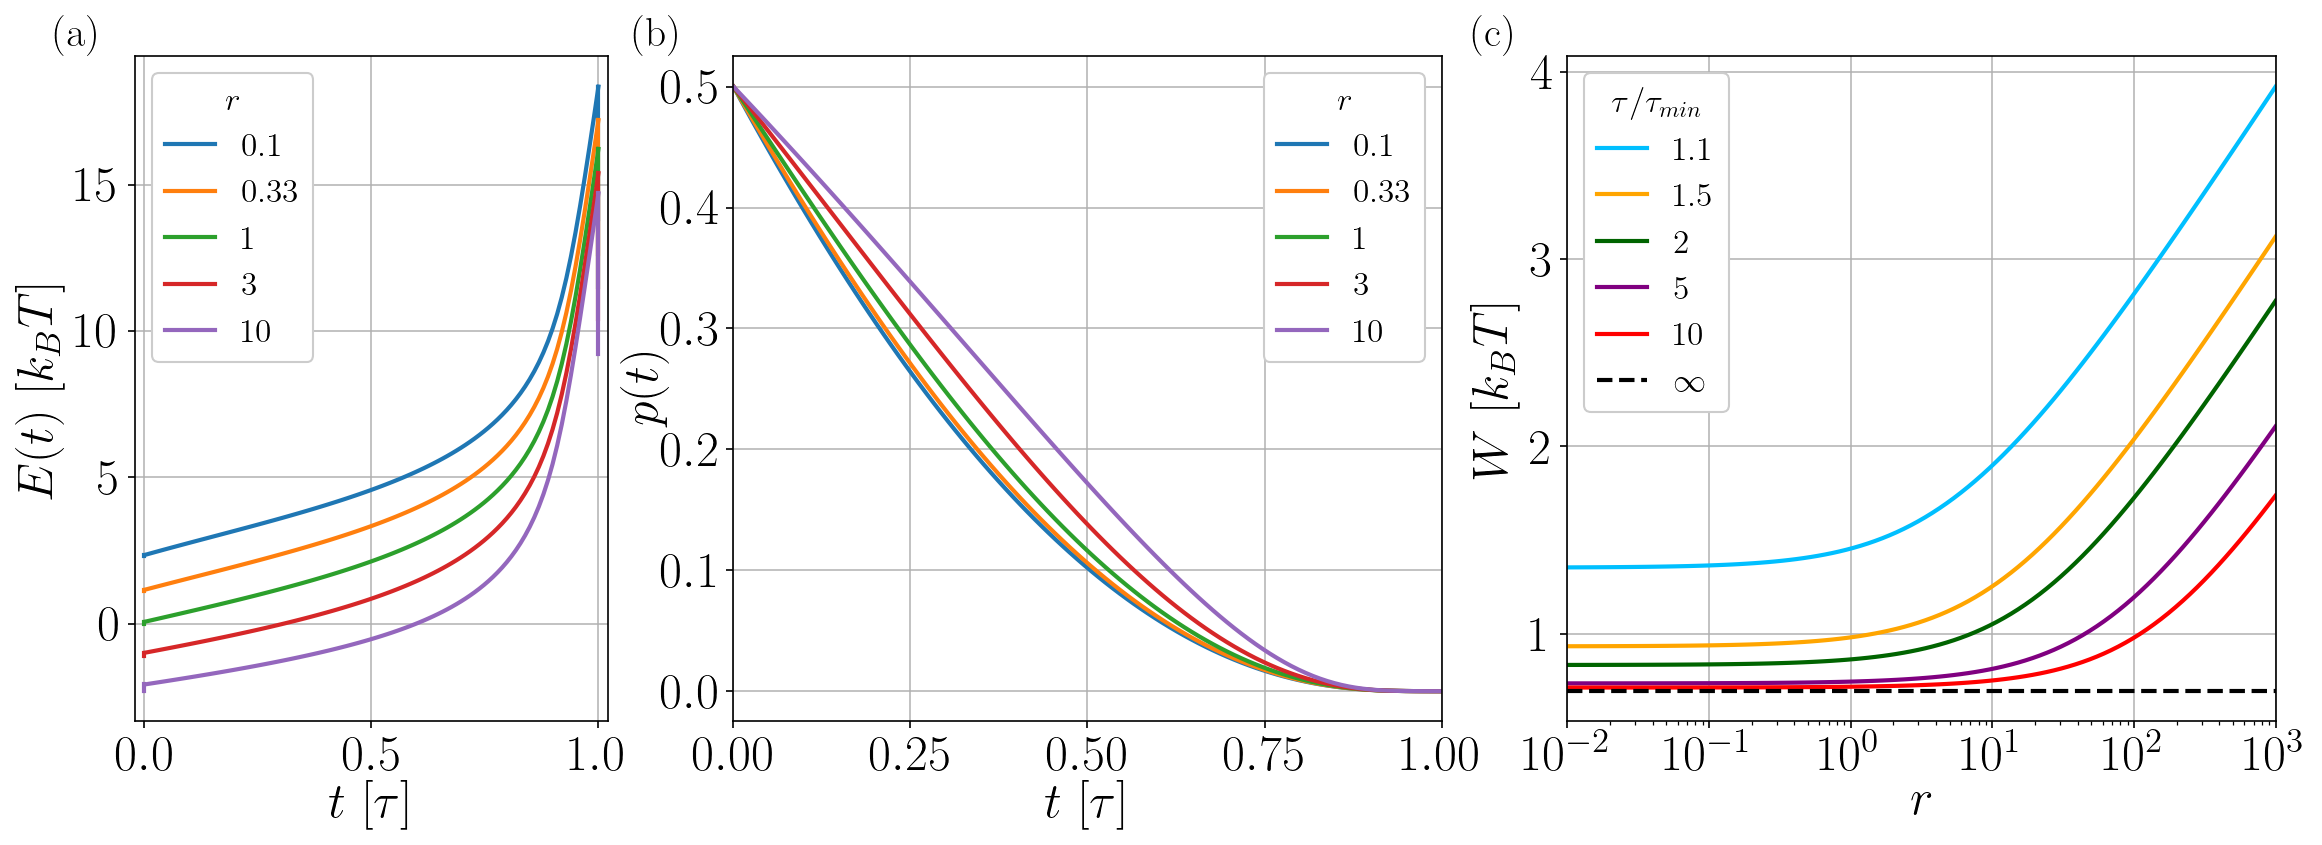

In [ ]:
# plot

cols = ['C0','C1','C2','C3','C4','deepskyblue','C6']

plt_w = 16
plt.rcParams.update({'font.size': 24, 'font.family': 'Times New Roman'})
font = fm.FontProperties(family='Times New Roman', style='normal', weight='normal', size=16)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=150,figsize=(plt_w,plt_w/2.6),gridspec_kw={'width_ratios': [2,3,3]})


lines = [] 
for i in range(len(r_list)):
    ax1.plot([0,0],[β*E0_list[i],β*(E_list[i,0])], linewidth=2, color=cols[i])
    l, = ax1.plot(t_list,β*(E_list[i]), linewidth=2, color=cols[i])
    ax1.plot([1,1],[β*(E_list[i,-1]), β*(Eτ_list[i])], linewidth=2, color=cols[i])
    ax2.plot(t_list, p_list[i], linewidth=2, color=cols[i])
    lines.append(l)

ax1.set_xlabel(r'$t~[\tau]$',labelpad=0)
ax2.set_xlabel(r'$t~[\tau]$',labelpad=0)
ax1.set_ylabel(r'$E(t)~[k_BT]$',labelpad=5)
ax2.set_ylabel(r'$p(t)$',labelpad=-5)
ax1.set_xlim([-0.02,1.02])
ax1.grid(alpha=0.9)
ax2.set_xlim([0,1])
ax2.grid(alpha=0.9)

cols = ['deepskyblue','orange','darkgreen','purple','red','C6']


ax1.legend(lines, r_list, loc='upper left', prop=font, handlelength=1.5, title=r'$r$', title_fontsize=16, framealpha=1)
ax2.legend(lines, r_list, loc='upper right', prop=font, handlelength=1.5, title=r'$r$', title_fontsize=16, framealpha=1)

lines2 = [] 
for i in range(len(τmult_list)):
    l, = ax3.plot(r_list2,β*W_list2[i], linewidth=2, color=cols[i])
    lines2.append(l)
l, = ax3.plot(r_list2,np.ones(r_list2.shape)*log(2), '--',linewidth=2, color='black')
lines2.append(l)

ax3.set_xlabel(r'$r$',labelpad=0)
ax3.set_ylabel(r'$W~[k_BT]$',labelpad=5)
ax3.set_xscale('log')
ax3.grid(alpha=0.9)
ax3.set_xlim([0.01,1000])

ax3.legend(lines2, τmult_list+[r'$\infty$'], loc='upper left',title = r'$\tau/\tau_{min}$', prop=font, handlelength=1.5, title_fontsize=16, framealpha=1)

ax1.text(-0.07, 1.00, r'(a)',verticalalignment='bottom', horizontalalignment='right',
        transform=ax1.transAxes, fontsize=20)
ax2.text(-0.07, 1.00, r'(b)',verticalalignment='bottom', horizontalalignment='right',
        transform=ax2.transAxes, fontsize=20)
ax3.text(-0.07, 1.00, r'(c)',verticalalignment='bottom', horizontalalignment='right',
        transform=ax3.transAxes, fontsize=20)

plt.tight_layout()
plt.subplots_adjust(wspace=0.20)

plt.savefig('landauer.pdf', dpi=500, format='pdf', bbox_inches='tight')
plt.show()